### Load Library

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
%matplotlib inline  

/Users/chenyun/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load Data as Dataframe

In [2]:
# Set data directory
dir = 'Data/'

print('loading aisles')
aislesDF = pd.read_csv(dir + 'aisles.csv')

print('loading departments')
departmentsDF = pd.read_csv(dir + 'departments.csv')

print('loading order_products_prior')
order_products_priorDF = pd.read_csv(dir + 'order_products__prior.csv', dtype = {
    'order_id':np.int32,
    'product_id':np.uint16,
    'add_to_cart_order': np.int16,
    'reordered': np.int8
})

print('loading order_products_train')
order_products_trainDF = pd.read_csv(dir + 'order_products__train.csv', dtype = {
    'order_id':np.int32,
    'product_id':np.uint16,
    'add_to_cart_order': np.int16,
    'reordered': np.int8
})

print('loading orders')

ordersDF = pd.read_csv(dir + 'orders.csv', dtype = {
    'order_id': np.int32,
    'user_id': np.int32,
    'eval_set': 'category',
    'order_number': np.int16,
    'order_dow': np.int8,
    'order_hour_of_day': np.int8,
    'days_since_prior_order': np.float32
})

print('loading products')
productsDF = pd.read_csv(dir + 'products.csv', dtype = {
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8
})

loading aisles
loading departments
loading order_products_prior
loading order_products_train
loading orders
loading products


In [3]:
# Check datasets structure
print('aislesDF {}: {}'.format(aislesDF.shape, ', '.join(aislesDF.columns)))
print('departmentsDF {}: {}'.format(departmentsDF.shape, ', '.join(departmentsDF.columns)))
print('order_products_priorDF {}: {}'.format(order_products_priorDF.shape, ', '.join(order_products_priorDF.columns)))
print('order_products_trainDF {}: {}'.format(order_products_trainDF.shape, ', '.join(order_products_trainDF.columns)))
print('ordersDF {}: {}'.format(ordersDF.shape, ', '.join(ordersDF.columns)))
print('productsDF {}: {}'.format(productsDF.shape, ', '.join(productsDF.columns)))

aislesDF (134, 2): aisle_id, aisle
departmentsDF (21, 2): department_id, department
order_products_priorDF (32434489, 4): order_id, product_id, add_to_cart_order, reordered
order_products_trainDF (1384617, 4): order_id, product_id, add_to_cart_order, reordered
ordersDF (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
productsDF (49688, 4): product_id, product_name, aisle_id, department_id


### Get Features for Products

In [4]:
# products: productsDF joins products
# get reorder_rate = reordersTotal / ordersTotal
products_raw = pd.DataFrame()

products_raw['ordersTotal'] = order_products_priorDF.groupby(
    order_products_priorDF.product_id).size().astype(np.int32)

products_raw['reordersTotal'] = order_products_priorDF['reordered'].groupby(
    order_products_priorDF.product_id).sum().astype(np.float32)

products_raw['reorder_rate'] = (products_raw.reordersTotal / products_raw.ordersTotal).astype(np.float32)

products = productsDF.join(products_raw, on = 'product_id')
# products_new.set_index('product_id', drop = False, inplace = True)

del products_raw

products.head()

,product_id,product_name,aisle_id,department_id,ordersTotal,reordersTotal,reorder_rate
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
1,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


### Get Features for Users

In [5]:
# priors: merge ordersDF to order_products_priorDF
ordersDF.set_index('order_id', inplace = True, drop = False)
priors = pd.merge(order_products_priorDF, ordersDF, how = 'left', on = 'order_id')

In [6]:
users = pd.DataFrame()
users['total_user'] = priors.groupby('product_id').size().astype(np.int16)
users['all_users'] = priors.groupby('product_id')['user_id'].apply(set)
users['total_distinct_users_perProduct'] = users.all_users.map(len)

In [7]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [8]:
# customers: total_items, all_products, total_unique_items,
# avgDaysBetwOrders, NumberOfOrders, avg_per_cart
customers_raw = pd.DataFrame()
customers_raw['avgDaysBetwOrders'] = ordersDF.groupby(
    'user_id')['days_since_prior_order'].mean().astype(np.float32)

customers_raw['NumberOfOrders'] = ordersDF.groupby('user_id').size().astype(np.int16)

In [9]:
customers = pd.DataFrame()

customers['total_items'] = priors.groupby('user_id').size().astype(np.int16)
customers['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
customers['total_unique_items'] = customers.all_products.map(len).astype(np.float32)

customers = customers.join(customers_raw)
customers['avg_per_cart'] = (customers.total_items / customers.NumberOfOrders).astype(np.float32)

In [10]:
del customers_raw
customers.head()

,total_items,all_products,total_unique_items,avgDaysBetwOrders,NumberOfOrders,avg_per_cart
user_id,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18.0,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102.0,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33.0,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17.0,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23.0,11.500000,5,7.400000


### Get Features for Users & Products

In [11]:
customerXproduct = priors.copy()
customerXproduct['user_product'] = (customerXproduct.product_id + 
                                    customerXproduct.user_id * 100000).astype(np.int64)

customerXproduct = customerXproduct.sort_values('order_number')

customerXproduct = customerXproduct.groupby('user_product', sort = False).agg(
{'order_id': ['size', 'last'], 'add_to_cart_order': 'sum'})

customerXproduct.columns = ['numbOfOrders', 'last_order_id','sum_add_to_cart_order']
customerXproduct.astype(
    {'numbOfOrders': np.int16, 'last_order_id': np.int32, 'sum_add_to_cart_order': np.int16}, 
    inplace=True)

,numbOfOrders,last_order_id,sum_add_to_cart_order
user_product,,,
8623906075,1,1520399,14
15429341329,1,2049062,3
15429323081,3,1489630,8
15429321527,3,2251505,14
15429335050,4,2251505,18
15429319893,1,2049062,7
15429309913,1,2049062,8
15429321903,1,2049062,9
15429342719,1,2049062,10


In [12]:
customerXproduct.head()

,numbOfOrders,last_order_id,sum_add_to_cart_order
user_product,,,
8623906075,1,1520399,14
15429341329,1,2049062,3
15429323081,3,1489630,8
15429321527,3,2251505,14
15429335050,4,2251505,18


In [13]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


### Define a Function to Get All Needed Features

In [14]:
def get_features(specified_orders, given_labels = False):
    print('create initial empty list')
    orders_list = []
    products_list = []
    labels = []
    
    training_index = set(order_products_trainDF.index)
    
    for row in specified_orders.itertuples():
        user_id = row.user_id
        order_id = row.order_id
        
        user_products = customers['all_products'][user_id]
        products_list += user_products
        orders_list += [order_id] * len(user_products)
        
        if given_labels:
            labels += [(order_id, product) in training_index for product in user_products]
        
    DF = pd.DataFrame({'order_id': orders_list, 'product_id': products_list}, dtype = np.int32)
    labels = np.array(labels, dtype = np.int8)
        
    print('get features for user part')
    DF['user_id'] = DF.order_id.map(ordersDF.user_id)
    DF['user_total_orders'] = DF.user_id.map(customers.NumberOfOrders)
    DF['user_total_items'] = DF.user_id.map(customers.total_items)
    DF['total_unique_items'] = DF.user_id.map(customers.total_unique_items)
    DF['user_avgDaysBetwOrders'] = DF.user_id.map(customers.avgDaysBetwOrders)
    DF['user_avg_per_cart'] = DF.user_id.map(customers.avg_per_cart) 
        
    print('get features for order part')
#     DF['dow'] = DF.order_id.map(ordersDF.order_dow)
    DF['order_hour_of_day'] = DF.order_id.map(ordersDF.order_hour_of_day)
    DF['days_since_prior_order'] = DF.order_id.map(ordersDF.days_since_prior_order)
    DF['daysSincePrior_avgDaysBetw_ratio'] = DF.days_since_prior_order / DF.user_avgDaysBetwOrders
        
    print('get features for product part')
    DF['aisle_id'] = DF.product_id.map(products.aisle_id)
    DF['department_id'] = DF.product_id.map(products.department_id)
    DF['product_order'] = DF.product_id.map(products.ordersTotal)
    DF['product_reorder'] = DF.product_id.map(products.reordersTotal)
    DF['product_reorder_rate'] = DF.product_id.map(products.reorder_rate)
    DF['product_distinct_user'] = DF.product_id.map(users.total_distinct_users_perProduct)
    
    print('get features for customerXproduct')
    DF['user_product_id']  = (DF.product_id + DF.user_id * 100000).astype(np.int64)
    DF.drop(['user_id'], axis = 1, inplace = True)
    DF['CP_numOrders'] = DF.user_product_id.map(customerXproduct.numbOfOrders)
    DF['CP_orders_ratio'] = DF.CP_numOrders / DF.user_total_orders
    DF['CP_last_order_id'] = DF.user_product_id.map(customerXproduct.last_order_id)
    DF['CP_avg_pos_inCart'] = DF.user_product_id.map(customerXproduct.sum_add_to_cart_order) / DF.CP_numOrders
    DF['CP_order_since_last'] = DF.user_total_orders - DF.CP_last_order_id.map(ordersDF.order_number)
    DF['CP_hour_vs_last'] = abs(DF.order_hour_of_day - DF.CP_last_order_id.map(
    ordersDF.order_hour_of_day)).map(lambda x: min(x, 24 - x)).astype(np.int8)
#     DF['CP_order_rate_since_first'] = DF.CP_numOrders / (DF.user_total_orders - DF.user_product_id.map(customerXproduct.first_order_id))
    
    DF.drop(['CP_last_order_id', 'user_product_id'], axis = 1, inplace = True)
    return(DF, labels)
        

### Split Training and Test sets

In [15]:
test = ordersDF[ordersDF.eval_set == 'test']
train = ordersDF[ordersDF.eval_set == 'train']

order_products_trainDF.set_index(['order_id', 'product_id'], inplace = True, drop = False)

### Get Training Set Features and Labels

In [16]:
df_to_train, train_labels = get_features(train, given_labels=True)

create initial empty list
get features for user part
get features for order part
get features for product part
get features for customerXproduct


### Get Test Set Features

In [17]:
df_to_test, _ = get_features(test)

create initial empty list
get features for user part
get features for order part
get features for product part
get features for customerXproduct


### Get Important Features to Train the Model

In [18]:
features_to_use = ['user_total_orders', 'user_total_items', 'total_unique_items', 
                  'user_avgDaysBetwOrders', 'user_avg_per_cart', 'order_hour_of_day',
                  'days_since_prior_order', 'daysSincePrior_avgDaysBetw_ratio',
                  'aisle_id', 'department_id', 'product_order', 'product_reorder',
                  'product_reorder_rate', 'CP_numOrders', 'CP_orders_ratio', 
                  'CP_avg_pos_inCart', 'CP_order_since_last', 'CP_hour_vs_last',
                  'product_distinct_user'] #'dow'

In [19]:
# Save features to csv
# df_to_train.to_csv('training_features.csv', sep = ',', index = False)
# a = pd.DataFrame(labels)
# a.to_csv('training_labels.csv', sep = ',', index = False)
# df_to_test.to_csv('test_features.csv', sep = ',', index = False)

### Xgboost Model Training

In [20]:
d_train = xgb.DMatrix(df_to_train, train_labels)

# Set parameters
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train")]
num_round = 80

In [21]:
bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=num_round, evals=watchlist,
               verbose_eval = 10)

[0]	train-logloss:0.625794
[10]	train-logloss:0.337321
[20]	train-logloss:0.27186
[30]	train-logloss:0.255275
[40]	train-logloss:0.251066
[50]	train-logloss:0.249728
[60]	train-logloss:0.249141
[70]	train-logloss:0.248775


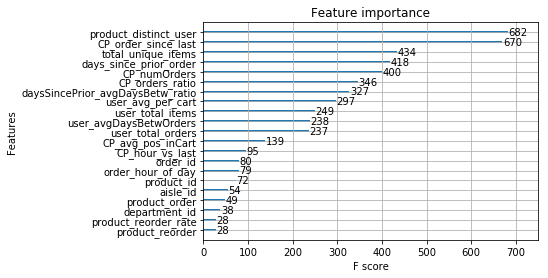

In [22]:
# Plot importance of predictors
xgb.plot_importance(bst)

In [23]:
threshold = 0.17 # We get the threshold in cross validation

In [24]:
preds = bst.predict(xgb.DMatrix(df_to_test))

df_to_test['pred'] = preds

d = dict()
for row in df_to_test.itertuples():
    if row.pred > threshold:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']

In [25]:
sub.head()

,order_id,products
0,2774568,17668 21903 32402 39190 47766 16797 18599 4396...
1,1528013,8424 21903 38293 25659
2,1376945,17794 33572 28465 27959 44632 34658 14947 3594...
3,1356845,14992 7076 28134 10863 21616 13176
4,2161313,11266 196 10441 12427 37710 48142 14715 27839


### Convert sub to csv File and Submit to Kaggle

In [26]:
sub.to_csv('sub.csv', index=False)